# Project title: Diabet Prediction [notebook 'Diabet_Prediction_Models']

## Authors: Denys Herasymuk & Yaroslav Morozevych

## Contents of This Notebook

Click on the section and go to this cell immediately. (works only with Jupyter in browser)

* [Section 1. Explore Data](#section_1)
* [Section 2. Train and Validate Models](#section_2)
* [Section 3. Test Set Evaluation](#section_3)

When you use `Run All` button with this notebook, you should wait approx. 3-5 mins to get output of all cells.

**How to run this notebook**

* Create a new virtual env with python 3.8
* In terminal run  -- `pip install -r requirements.txt`

## General Configuration

In [1]:
import os
import sys
import math
import pickle
import sklearn
import itertools
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgbm
import matplotlib.pyplot as plt

from pprint import pprint
from copy import deepcopy
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier

from utils import scale_normalize

In [2]:
%matplotlib inline

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100
matplotlib.rcParams['figure.figsize'] = 15, 5

# import warnings
# warnings.filterwarnings('ignore')

## Python & Library Versions

In [3]:
versions = ( ("matplotlib", matplotlib.__version__),
             ("numpy", np.__version__),
             ("pandas", pd.__version__),
             ("seaborn", sns.__version__),
             ("sklearn", sklearn.__version__),
             )

print(sys.version, "\n")
print("library" + " " * 4 + "version")
print("-" * 18)

for tup1, tup2 in versions:
    print("{:11} {}".format(tup1, tup2))

3.8.12 (default, Oct 12 2021, 13:49:34) 
[GCC 7.5.0] 

library    version
------------------
matplotlib  3.5.1
numpy       1.19.2
pandas      1.3.5
seaborn     0.11.2
sklearn     1.0.1


<a id='section_1'></a>

## Section 1. Explore Data

In [4]:
diabetes_df = pd.read_csv(os.path.join(".", "data", "diabetes_processed.csv"))
diabetes_df = diabetes_df.iloc[: , 1:] # Drop first column of dataframe

In [5]:
diabetes_df.head()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
0,6,148,0,33.6,0.627,50,1.69,1
1,1,85,0,26.6,0.351,31,0.66,0
2,8,183,0,23.3,0.672,32,1.61,1
3,1,89,94,28.1,0.167,21,0.07,0
4,0,137,168,43.1,2.288,33,1.27,1


### Validate Data

In [6]:
diabetes_df.describe()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,79.799479,31.992578,0.471876,33.240885,0.888828,0.348958
std,3.369578,31.972618,115.244002,7.884160,0.331329,11.760232,0.503496,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000,0.000000
25%,1.000000,99.000000,0.000000,27.300000,0.243750,24.000000,0.470000,0.000000
50%,3.000000,117.000000,30.500000,32.000000,0.372500,29.000000,0.870000,0.000000
75%,6.000000,140.250000,127.250000,36.600000,0.626250,41.000000,1.230000,1.000000
max,17.000000,199.000000,846.000000,67.100000,2.420000,81.000000,2.250000,1.000000


In [7]:
diabetes_df.isnull().sum()

Pregnancies                 0
Glucose                     0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
DiabetesRisk                0
Outcome                     0
dtype: int64

In [8]:
# Selecting duplicate rows except first.
# Occurrence based on all columns
duplicates = diabetes_df[diabetes_df.duplicated()]

print("Duplicate rows :")
duplicates

Duplicate rows :


,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk,Outcome


<a id='section_2'></a>

## Section 2. Train and Validate Models

### Prepare Data

In [9]:
# choose the most relevant features based on data analysis in 01_Process_Data_and_EDA.ipynb
features = ["Pregnancies", "Glucose", "Insulin", "BMI", "DiabetesPedigreeFunction", "Age", "DiabetesRisk", "Outcome"]
scaled_df = scale_normalize(df=diabetes_df, features=features)

In [10]:
# separate the dataframe onto features and target
features_df = scaled_df.drop("Outcome", axis="columns")
target_df = diabetes_df[['Outcome']]

In [11]:
SEED = 25
n_folds = 3

# split the data on test and train
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df, test_size=0.2, random_state=SEED)
samples_per_fold = len(y_test)
X_train.describe()

,Pregnancies,Glucose,Insulin,BMI,DiabetesPedigreeFunction,Age,DiabetesRisk
count,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000,614.000000
mean,-0.000901,0.012476,0.012192,0.002368,0.007752,0.024265,0.013011
std,1.012489,1.011829,1.010449,1.004225,1.034108,0.996093,0.998618
min,-1.141852,-3.783654,-0.692891,-4.060474,-1.189553,-1.041549,-1.766465
25%,-0.844885,-0.685236,-0.692891,-0.595578,-0.687458,-0.786286,-0.832383
50%,-0.250952,-0.121888,-0.397672,0.000942,-0.322779,-0.360847,-0.037419
75%,0.639947,0.629244,0.435886,0.584771,0.467737,0.660206,0.678048
max,3.906578,2.444478,6.652839,4.455807,5.883565,3.297926,2.705205


### Random over-sampling with imblearn

In [12]:
target_df.value_counts()

Outcome
0          500
1          268
dtype: int64

In [13]:
from imblearn.over_sampling import RandomOverSampler

ros = RandomOverSampler(random_state=42)

# fit predictor and target variable
x_ros, y_ros = ros.fit_resample(features_df, target_df)

print('Original dataset shape', len(target_df))
print('Resample dataset shape', len(y_ros))

Original dataset shape 768
Resample dataset shape 1000


In [14]:
ros_X_train, ros_X_test, ros_y_train, ros_y_test = train_test_split(x_ros, y_ros, test_size=0.2, random_state=SEED)

### Synthetic Minority Oversampling Technique (SMOTE)

In [15]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
x_smote, y_smote = smote.fit_resample(features_df, target_df)

print('Original dataset shape', len(target_df))
print('Resample dataset shape', len(y_smote))

smote_X_train, smote_X_test, smote_y_train, smote_y_test = train_test_split(x_smote, y_smote, test_size=0.2, random_state=SEED)

Original dataset shape 768
Resample dataset shape 1000


### Train and Validation

In [48]:
best_results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                   'Accuracy_Score',
                                   'Model_Best_Params', 'Model_Pred'))

In [49]:
def folds_iterator(n_folds, samples_per_fold, size):
    """
    Iterator for GridSearch based on Cross-Validation

    :param n_folds: number of folds for Cross-Validation
    :param samples_per_fold: number of samples per fold
    """
    for i in range(n_folds):
        yield np.arange(0, size - samples_per_fold * (i + 1)), \
              np.arange(size - samples_per_fold * (i + 1), size - samples_per_fold * i)


In [50]:
def validate_model(model, x, y, params, n_folds, samples_per_fold):
    """
    Use GridSearchCV for a special model to find the best hyperparameters based on validation set
    """
    grid_search = GridSearchCV(estimator=model,
                               param_grid=params,
                               scoring={
                                   "F1_Score": make_scorer(f1_score, average='macro'),
                                   "Accuracy_Score": make_scorer(accuracy_score),
                               },
                               refit="F1_Score",
                               n_jobs=-1,
                               cv=folds_iterator(n_folds, samples_per_fold, x.shape[0]))
    grid_search.fit(x, y.values.ravel())
    best_index = grid_search.best_index_

    return grid_search.best_estimator_,\
           grid_search.cv_results_["mean_test_F1_Score"][best_index],\
           grid_search.cv_results_["mean_test_Accuracy_Score"][best_index],\
           grid_search.best_params_


def test_evaluation(cur_best_model, model_name, cur_best_params,
                    cur_x_train, cur_y_train, cur_x_test, cur_y_test,
                    dataset_title, show_plots, debug_mode):
    cur_best_model.fit(cur_x_train, cur_y_train.values.ravel()) # refit model on the whole train set
    cur_model_pred = cur_best_model.predict(cur_x_test)
    test_f1_score = f1_score(cur_y_test, cur_model_pred, average='macro')
    test_accuracy = accuracy_score(cur_y_test, cur_model_pred)

    if debug_mode:
        print("#" * 20, f' {dataset_title} ', "#" * 20)
        print('Test model: ', model_name)
        print('Test model parameters:')
        pprint(cur_best_params)

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        if show_plots:
            # plot the confusion matrix
            cm = confusion_matrix(cur_y_test, cur_model_pred, labels=cur_best_model.classes_)
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
            disp.plot()
            plt.show()
    return test_f1_score, test_accuracy, cur_model_pred


#### Validate ML Models

In this part we find the best ML model among RandomForestClassifier, DecisionTreeClassifier and SVM.

In [51]:
def validate_ML_models(best_results_df, X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode):
    """
    Find the best model from defined list.
    Tune each model on a validation set with GridSearchCV and
    return best_model with its hyperparameters, which has the highest F1 score
    """
    results_df = pd.DataFrame(columns=('Dataset_Name', 'Model_Name', 'F1_Score',
                                       'Accuracy_Score',
                                       'Model_Best_Params'))

    config_models = [
        {
            'model_name': 'RandomForestClassifier',
            'model': RandomForestClassifier(random_state=SEED),
            'params': {
                "bootstrap": [True, False],
                "max_depth": [3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "n_estimators": [5 * i for i in range(1, 7)],
                "max_features": [0.6, 'auto', 'sqrt']
            }
        },
        {
            'model_name': 'DecisionTreeClassifier',
            'model': DecisionTreeClassifier(random_state=SEED),
            'params': {
                "max_depth": [2, 3, 4, 6, 10],
                "min_samples_split": [2, 6],
                "min_samples_leaf": [1, 2, 4],
                "max_features": [0.6, 'auto', 'sqrt'],
                "criterion": ["gini", "entropy"]
            }
        },
        {
            'model_name': 'SVC',
            'model': SVC(random_state=SEED),
            'params': {
                'C': [0.1, 1, 10, 100, 1000],
                'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                'kernel': ['rbf'],
                # 'class_weight': ['balanced'], # shown bad performance
            }
        },

        # For XGBoost parameters tuning we used this article --
        # https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
        #
        # For faster running this notebook we left only the best combination of parameters,
        # but for experiments e used next ones:
        # 'params': {
        #     'learning_rate': [0.1],
        #     'n_estimators': [100],
        #     'max_depth': range(3,10,2),
        #     'min_child_weight': range(1,6,2),
        #     'gamma': [i/10.0 for i in range(0,5)],
        #     'objective':  ['binary:logistic'],
        #     'nthread': [8]
        # }
        #
        {
            'model_name': 'XGBClassifier',
            'model': XGBClassifier(random_state=SEED),
            'params': {
                'learning_rate': [0.1],
                'n_estimators': [100],
                'max_depth': [4],
                'min_child_weight': [1],
                'gamma': [0.3],
                'objective':  ['binary:logistic'],
                'nthread': [8]
            }
        },
    ]

    best_f1_score = -np.Inf
    best_accuracy = -np.Inf
    best_model_name = 'No model'
    best_params = None
    idx = 0
    for model_config in config_models:
        cur_model, cur_f1_score, cur_accuracy, cur_params = validate_model(deepcopy(model_config['model']),
                                                                    X_train, y_train, model_config['params'],
                                                                    n_folds, samples_per_fold)

        test_f1_score, test_accuracy, cur_model_pred = test_evaluation(cur_model, model_config['model_name'], cur_params,
                                                       X_train, y_train, X_test, y_test, dataset_title, show_plots, debug_mode)
        results_df.loc[idx] = [dataset_title,
                               model_config['model_name'],
                               test_f1_score,
                               test_accuracy,
                               cur_params]
        idx += 1

        if test_f1_score > best_f1_score:
            best_f1_score = test_f1_score
            best_accuracy = test_accuracy
            best_model_name = model_config['model_name']
            best_params = cur_params

    best_results_df.loc[best_results_df.shape[0]] = [dataset_title,
                                                     best_model_name,
                                                     best_f1_score,
                                                     best_accuracy,
                                                     best_params,
                                                     cur_model_pred]

    return results_df

####################  Original Dataset  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': False,
 'max_depth': 6,
 'max_features': 'auto',
 'min_samples_leaf': 4,
 'min_samples_split': 2,
 'n_estimators': 15}

              precision    recall  f1-score   support

           0      0.827     0.883     0.854       103
           1      0.727     0.627     0.674        51

    accuracy                          0.799       154
   macro avg      0.777     0.755     0.764       154
weighted avg      0.794     0.799     0.795       154



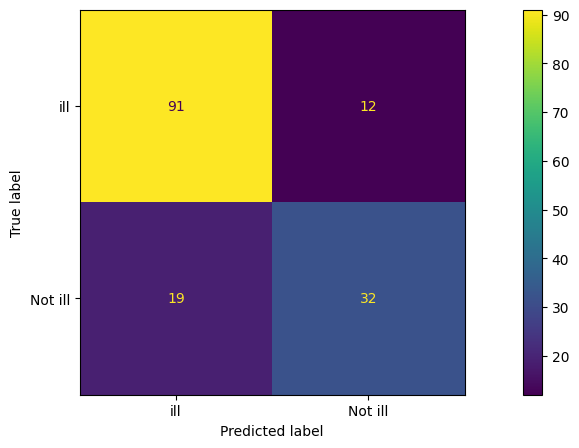

####################  Original Dataset  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'gini',
 'max_depth': 3,
 'max_features': 0.6,
 'min_samples_leaf': 1,
 'min_samples_split': 2}

              precision    recall  f1-score   support

           0      0.725     0.971     0.830       103
           1      0.812     0.255     0.388        51

    accuracy                          0.734       154
   macro avg      0.769     0.613     0.609       154
weighted avg      0.754     0.734     0.684       154



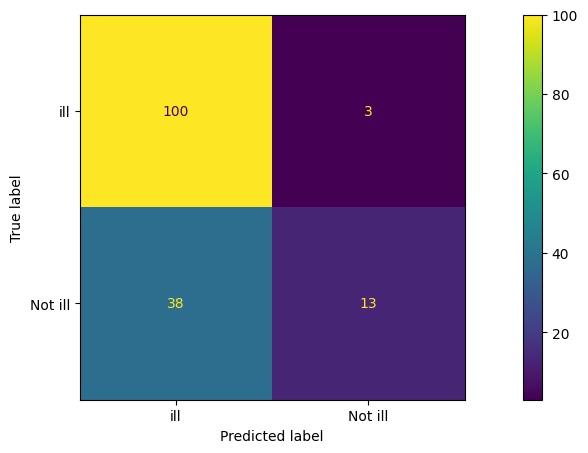

####################  Original Dataset  ####################
Test model:  SVC
Test model parameters:
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0      0.796     0.874     0.833       103
           1      0.683     0.549     0.609        51

    accuracy                          0.766       154
   macro avg      0.740     0.711     0.721       154
weighted avg      0.759     0.766     0.759       154



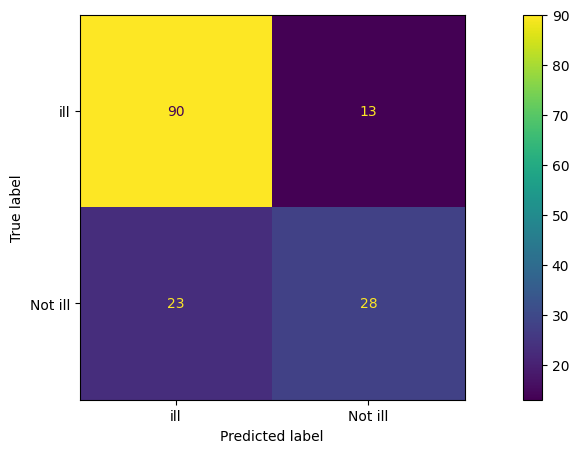

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
####################  Original Dataset  ####################
Test model:  XGBClassifier
Test model parameters:
{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': 8,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.827     0.883     0.854       103
           1      0.727     0.627     0.674        51

    accuracy                          0.799       154
   macro avg     

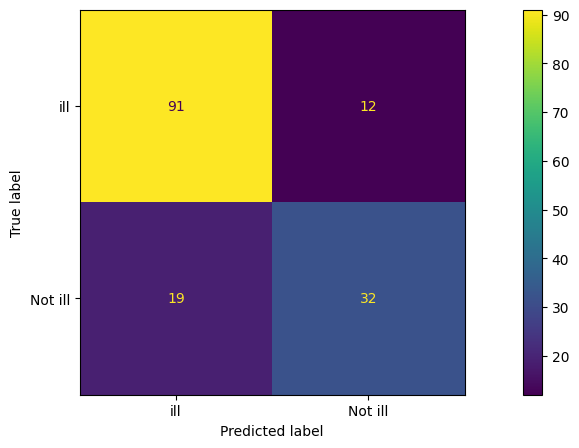

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Original Dataset,RandomForestClassifier,0.764072,0.798701,"{'bootstrap': False, 'max_depth': 6, 'max_feat..."
1,Original Dataset,DecisionTreeClassifier,0.608968,0.733766,"{'criterion': 'gini', 'max_depth': 3, 'max_fea..."
2,Original Dataset,SVC,0.721014,0.766234,"{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}"
3,Original Dataset,XGBClassifier,0.764072,0.798701,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [52]:
ML_results_df = validate_ML_models(best_results_df, X_train, y_train, X_test, y_test, "Original Dataset", show_plots=True, debug_mode=True)
ML_results_df

####################  ROS Dataset  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': True,
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'n_estimators': 25}

              precision    recall  f1-score   support

           0      0.979     0.913     0.945       103
           1      0.845     0.961     0.899        51

    accuracy                          0.929       154
   macro avg      0.912     0.937     0.922       154
weighted avg      0.935     0.929     0.930       154



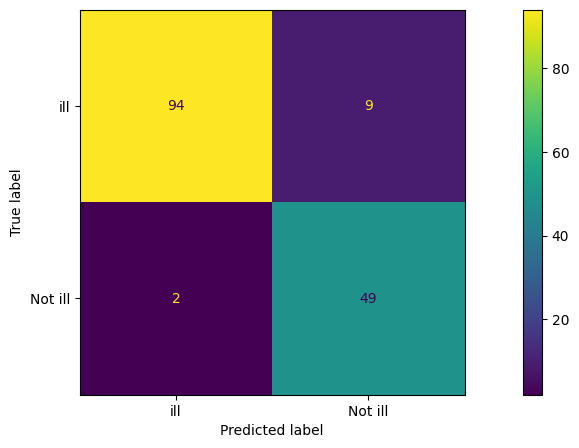

####################  ROS Dataset  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy',
 'max_depth': 10,
 'max_features': 'auto',
 'min_samples_leaf': 1,
 'min_samples_split': 2}

              precision    recall  f1-score   support

           0      0.919     0.883     0.901       103
           1      0.782     0.843     0.811        51

    accuracy                          0.870       154
   macro avg      0.851     0.863     0.856       154
weighted avg      0.874     0.870     0.871       154



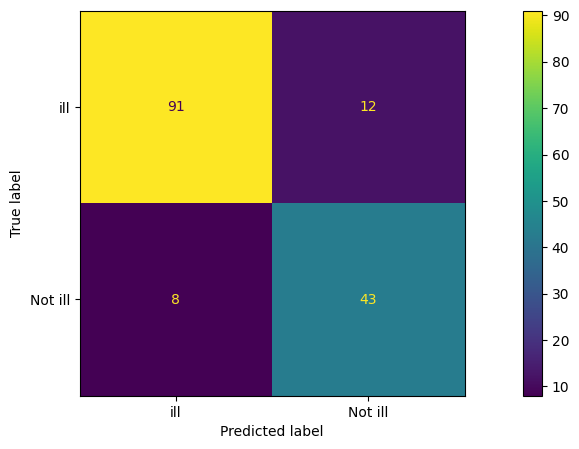

####################  ROS Dataset  ####################
Test model:  SVC
Test model parameters:
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0      0.922     0.922     0.922       103
           1      0.843     0.843     0.843        51

    accuracy                          0.896       154
   macro avg      0.883     0.883     0.883       154
weighted avg      0.896     0.896     0.896       154



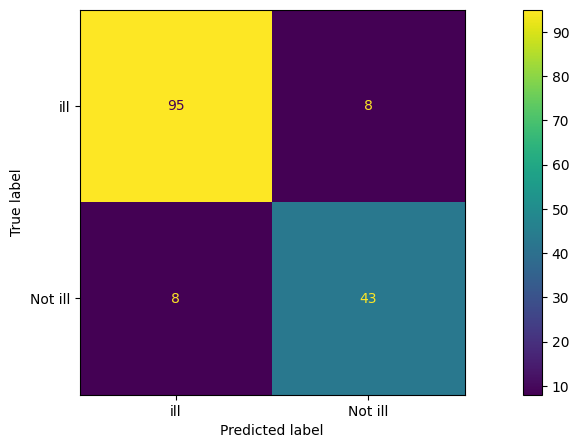

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:20:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:20:58] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
####################  ROS Dataset  ####################
Test model:  XGBClassifier
Test model parameters:
{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': 8,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.938     0.874     0.905       103
           1      0.776     0.882     0.826        51

    accuracy                          0.877       154
   macro avg      0.85

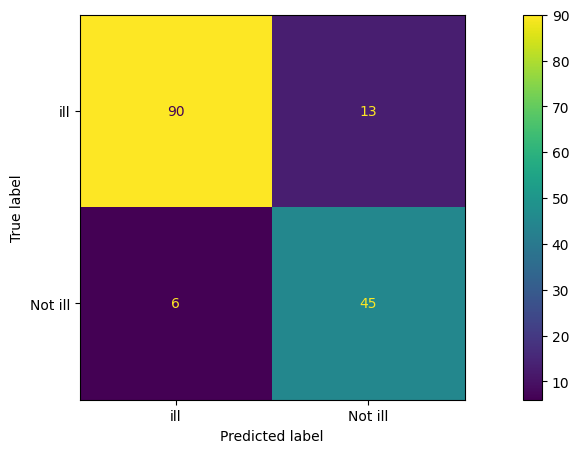

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,ROS Dataset,RandomForestClassifier,0.921903,0.928571,"{'bootstrap': True, 'max_depth': 10, 'max_feat..."
1,ROS Dataset,DecisionTreeClassifier,0.856155,0.870130,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,ROS Dataset,SVC,0.882734,0.896104,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}"
3,ROS Dataset,XGBClassifier,0.865105,0.876623,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [53]:
ros_ML_results_df = validate_ML_models(best_results_df, ros_X_train, ros_y_train, X_test, y_test, "ROS Dataset", show_plots=True, debug_mode=True)
ros_ML_results_df

####################  SMOTE Dataset  ####################
Test model:  RandomForestClassifier
Test model parameters:
{'bootstrap': False,
 'max_depth': 10,
 'max_features': 0.6,
 'min_samples_leaf': 2,
 'min_samples_split': 2,
 'n_estimators': 15}

              precision    recall  f1-score   support

           0      0.960     0.932     0.946       103
           1      0.870     0.922     0.895        51

    accuracy                          0.929       154
   macro avg      0.915     0.927     0.921       154
weighted avg      0.930     0.929     0.929       154



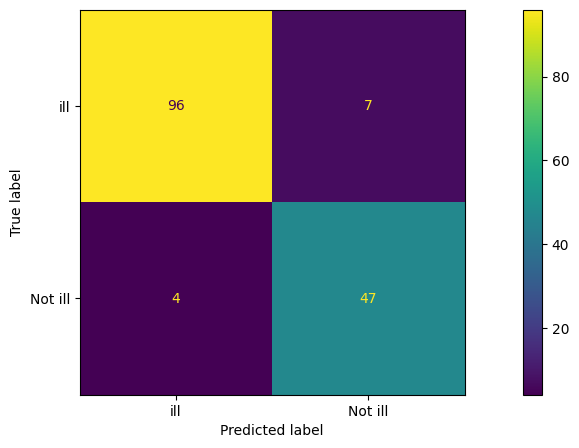

####################  SMOTE Dataset  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy',
 'max_depth': 6,
 'max_features': 0.6,
 'min_samples_leaf': 2,
 'min_samples_split': 6}

              precision    recall  f1-score   support

           0      0.859     0.825     0.842       103
           1      0.673     0.725     0.698        51

    accuracy                          0.792       154
   macro avg      0.766     0.775     0.770       154
weighted avg      0.797     0.792     0.794       154



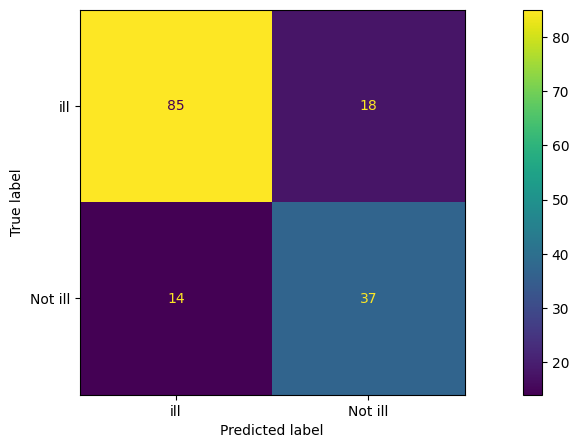

####################  SMOTE Dataset  ####################
Test model:  SVC
Test model parameters:
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0      0.924     0.942     0.933       103
           1      0.878     0.843     0.860        51

    accuracy                          0.909       154
   macro avg      0.901     0.892     0.896       154
weighted avg      0.908     0.909     0.909       154



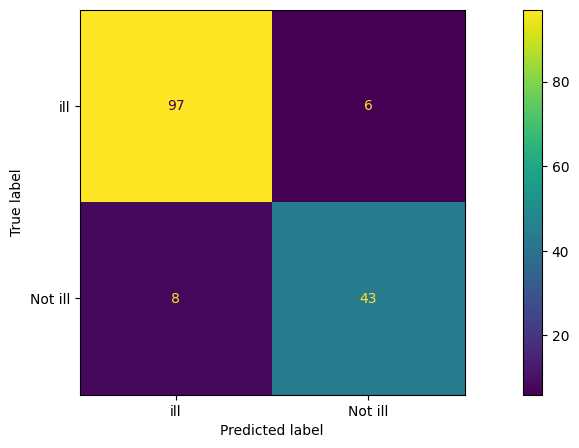

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[13:21:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[13:21:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
####################  SMOTE Dataset  ####################
Test model:  XGBClassifier
Test model parameters:
{'gamma': 0.3,
 'learning_rate': 0.1,
 'max_depth': 4,
 'min_child_weight': 1,
 'n_estimators': 100,
 'nthread': 8,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.958     0.883     0.919       103
           1      0.797     0.922     0.855        51

    accuracy                          0.896       154
   macro avg      0.

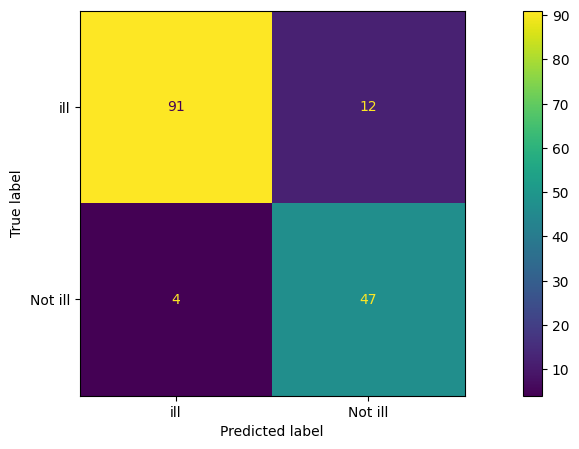

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,SMOTE Dataset,RandomForestClassifier,0.920525,0.928571,"{'bootstrap': False, 'max_depth': 10, 'max_fea..."
1,SMOTE Dataset,DecisionTreeClassifier,0.769849,0.792208,"{'criterion': 'entropy', 'max_depth': 6, 'max_..."
2,SMOTE Dataset,SVC,0.896346,0.909091,"{'C': 1, 'gamma': 1, 'kernel': 'rbf'}"
3,SMOTE Dataset,XGBClassifier,0.886869,0.896104,"{'gamma': 0.3, 'learning_rate': 0.1, 'max_dept..."


In [54]:
smote_ML_results_df = validate_ML_models(best_results_df, smote_X_train, smote_y_train, X_test, y_test, "SMOTE Dataset",
                                         show_plots=True, debug_mode=True)
smote_ML_results_df

In [55]:
def display_models_info(best_results_df):
    for i in range(best_results_df.shape[0]):
        model_name, dataset_title, cur_model_pred = best_results_df.at[i, 'Model_Name'], best_results_df.at[i, 'Dataset_Name'],\
                                                    best_results_df.at[i, 'Model_Pred']
        print('\n', "#" * 20, f' {dataset_title} ', "#" * 20)
        print('Model name: ', model_name)

        # title_to_df = {
        #     "Original Dataset": y_test,
        #     "ROS Dataset": ros_y_test,
        #     "SMOTE Dataset": smote_y_test,
        # }
        cur_y_test = y_test

        # print the scores
        print()
        print(classification_report(cur_y_test, cur_model_pred, digits=3))

        # plot the confusion matrix
        cm = confusion_matrix(cur_y_test, cur_model_pred)
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
        disp.plot()
        plt.show()

In [56]:
best_results_df

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params,Model_Pred
0,Original Dataset,RandomForestClassifier,0.764072,0.798701,"{'bootstrap': False, 'max_depth': 6, 'max_feat...","[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
1,ROS Dataset,RandomForestClassifier,0.921903,0.928571,"{'bootstrap': True, 'max_depth': 10, 'max_feat...","[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,SMOTE Dataset,RandomForestClassifier,0.920525,0.928571,"{'bootstrap': False, 'max_depth': 10, 'max_fea...","[0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."



 ####################  Original Dataset  ####################
Model name:  RandomForestClassifier

              precision    recall  f1-score   support

           0      0.827     0.883     0.854       103
           1      0.727     0.627     0.674        51

    accuracy                          0.799       154
   macro avg      0.777     0.755     0.764       154
weighted avg      0.794     0.799     0.795       154



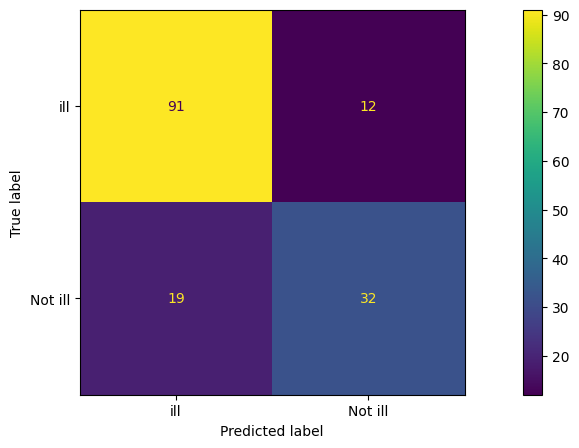


 ####################  ROS Dataset  ####################
Model name:  RandomForestClassifier

              precision    recall  f1-score   support

           0      0.938     0.874     0.905       103
           1      0.776     0.882     0.826        51

    accuracy                          0.877       154
   macro avg      0.857     0.878     0.865       154
weighted avg      0.884     0.877     0.878       154



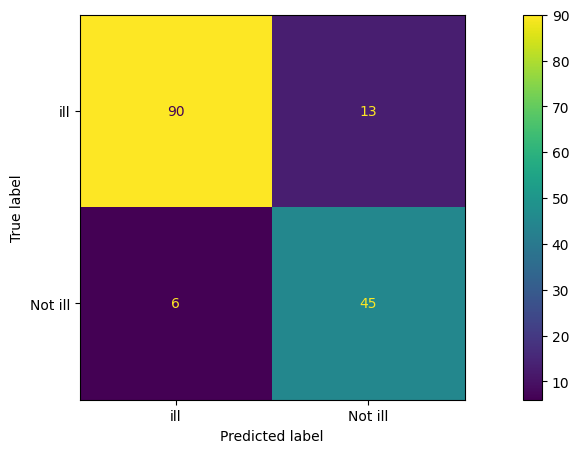


 ####################  SMOTE Dataset  ####################
Model name:  RandomForestClassifier

              precision    recall  f1-score   support

           0      0.958     0.883     0.919       103
           1      0.797     0.922     0.855        51

    accuracy                          0.896       154
   macro avg      0.877     0.903     0.887       154
weighted avg      0.904     0.896     0.898       154



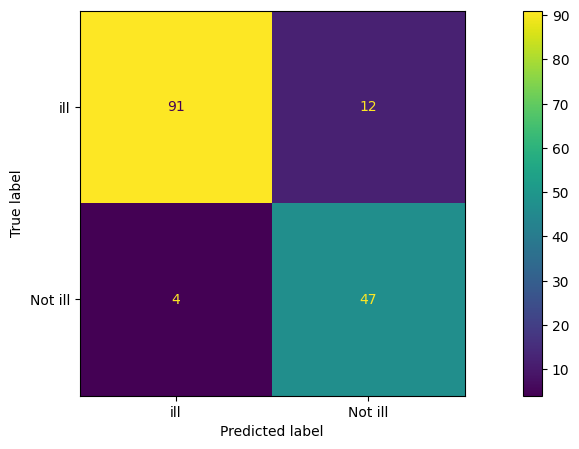

In [57]:
display_models_info(best_results_df)

### Validate DL models

In [128]:
def validate_MLPClassifier(X_train_scaled, y_train, debug_mode=False):
    vmlp = MLPClassifier(max_iter=100, random_state=SEED)

    # parameter_space = {
    #     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    #     'activation': ['tanh', 'relu'],
    #     'solver': ['sgd', 'adam'],
    #     'alpha': [0.0001, 0.05],
    #     'learning_rate': ['constant','adaptive'],
    # }
    parameter_space = {
        'hidden_layer_sizes': [(100,)],
        'activation': ['tanh'],
        'solver': ['adam'],
        'alpha': [0.0001],
        'learning_rate': ['constant'],
    }
    clf = GridSearchCV(vmlp,
                       parameter_space,
                       n_jobs=-1,
                       cv=3,
                       scoring={
                           "F1_Score": make_scorer(f1_score, average='macro'),
                           "Accuracy_Score": make_scorer(accuracy_score),
                       },
                       refit="F1_Score")
    clf.fit(X_train_scaled, y_train)

    # All results
    if debug_mode:
        means = clf.cv_results_['mean_test_score']
        stds = clf.cv_results_['std_test_score']
        for mean, std, params in zip(means, stds, clf.cv_results_['params']):
            print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

    best_index = clf.best_index_
    return clf.best_estimator_,\
           clf.cv_results_["mean_test_F1_Score"][best_index],\
           clf.cv_results_["mean_test_Accuracy_Score"][best_index],\
           clf.best_params_


def validate_DL_models(X_train, y_train, debug_mode=False):
    # scaler = StandardScaler()
    # X_train_scaled = scaler.fit_transform(X_train)
    cur_model, cur_f1_score, cur_accuracy, cur_params = validate_MLPClassifier(X_train, y_train, debug_mode)

    # if debug_mode:
    # print('\nModel name: ', model_config['model_name'])
    print('\nModel name: ', "MLPClassifier")
    print('Best model validation params: ')
    print('Mean Test F1 Score: ', cur_f1_score)
    print('Mean Test Accuracy Score: ', cur_accuracy)
    pprint(cur_params)


In [129]:
validate_DL_models(X_train, y_train)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



Model name:  MLPClassifier
Best model validation params: 
Mean Test F1 Score:  0.7433851451066024
Mean Test Accuracy Score:  0.7736489717838354
{'activation': 'tanh',
 'alpha': 0.0001,
 'hidden_layer_sizes': (100,),
 'learning_rate': 'constant',
 'solver': 'adam'}


#### MLPClassifier

In [116]:
# from sklearn.preprocessing import StandardScaler
#
# scaler = StandardScaler()
# X_train_scaled = scaler.fit_transform(X_train)
# X_test_scaled = scaler.fit_transform(X_test)

In [51]:
vmlp = MLPClassifier(max_iter=100, random_state=SEED)

parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}


In [52]:
clf = GridSearchCV(vmlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


GridSearchCV(cv=3, estimator=MLPClassifier(max_iter=100, random_state=25),
             n_jobs=-1,
             param_grid={'activation': ['tanh', 'relu'],
                         'alpha': [0.0001, 0.05],
                         'hidden_layer_sizes': [(50, 50, 50), (50, 100, 50),
                                                (100,)],
                         'learning_rate': ['constant', 'adaptive'],
                         'solver': ['sgd', 'adam']})

In [53]:
# Best parameter set
print(f'Best parameters found: \n{clf.best_params_}\n\n\n')
debug_mode = False

# All results
if debug_mode:
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

Best parameters found: 
{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100,), 'learning_rate': 'constant', 'solver': 'adam'}





Results on the test set:
              precision    recall  f1-score   support

           0       0.82      0.86      0.84       103
           1       0.70      0.63      0.66        51

    accuracy                           0.79       154
   macro avg       0.76      0.75      0.75       154
weighted avg       0.78      0.79      0.78       154



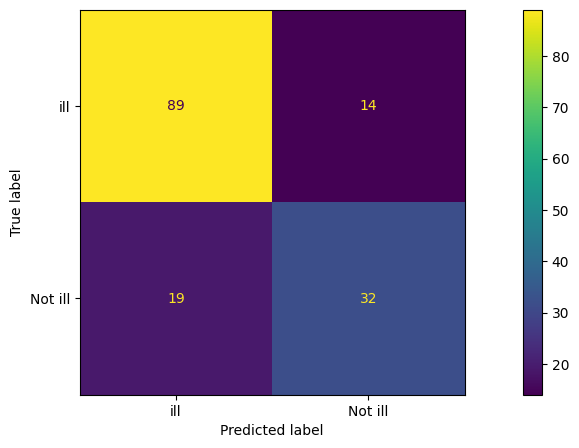

In [54]:
y_true, y_pred = y_test , clf.predict(X_test)

print('Results on the test set:')
print(classification_report(y_true, y_pred))

# plot the confusion matrix
cm = confusion_matrix(y_true, y_pred, labels=clf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
disp.plot()
plt.show()

#### LGBM

In [56]:
model = lgbm.LGBMClassifier(learning_rate=0.09,max_depth=-5,random_state=SEED)
model.fit(X_train,y_train,eval_set=[(X_test,y_test),(X_train,y_train)],
          verbose=20,eval_metric='logloss')

/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/lightgbm/sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of Light

[20]	training's binary_logloss: 0.341109	valid_0's binary_logloss: 0.48101
[40]	training's binary_logloss: 0.235511	valid_0's binary_logloss: 0.512825
[60]	training's binary_logloss: 0.166129	valid_0's binary_logloss: 0.543416
[80]	training's binary_logloss: 0.11864	valid_0's binary_logloss: 0.571903
[100]	training's binary_logloss: 0.0848308	valid_0's binary_logloss: 0.622407


LGBMClassifier(learning_rate=0.09, max_depth=-5, random_state=25)

In [57]:
print('Training accuracy {:.4f}'.format(model.score(X_train,y_train)))
print('Testing accuracy {:.4f}'.format(model.score(X_test,y_test)))

Training accuracy 1.0000
Testing accuracy 0.7727


<AxesSubplot:title={'center':'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

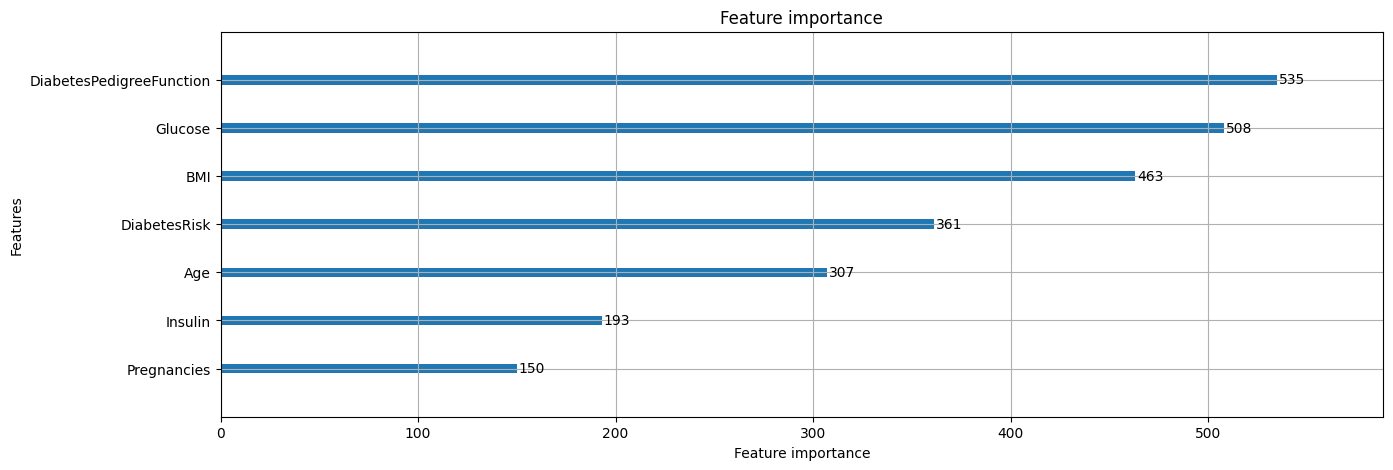

In [58]:
lgbm.plot_importance(model)

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='binary_logloss'>

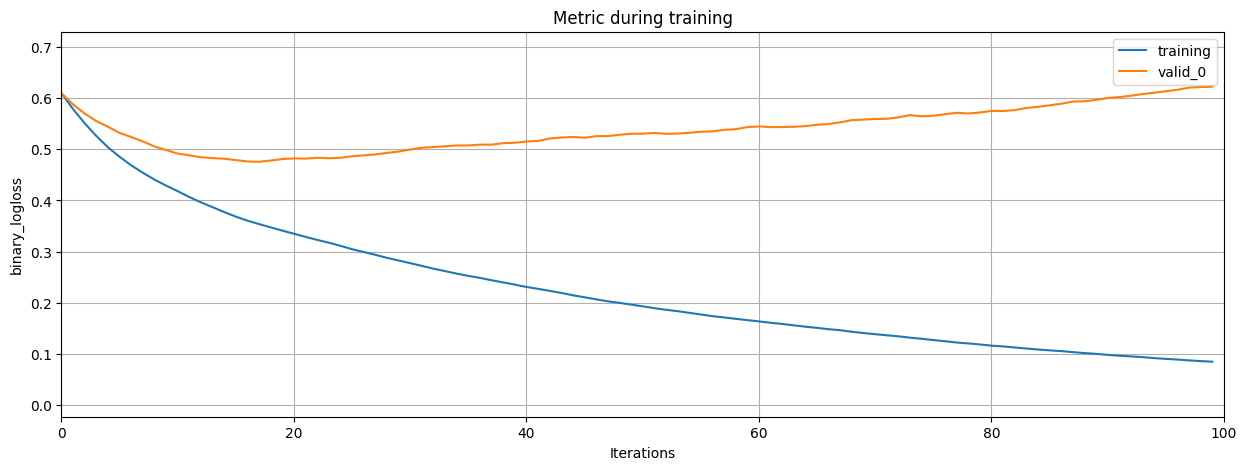

In [59]:
lgbm.plot_metric(model)

              precision    recall  f1-score   support

           0       0.82      0.84      0.83       103
           1       0.67      0.63      0.65        51

    accuracy                           0.77       154
   macro avg       0.74      0.74      0.74       154
weighted avg       0.77      0.77      0.77       154



/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


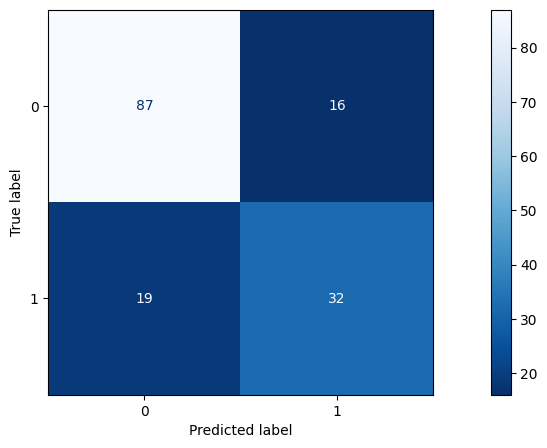

In [62]:
from sklearn import metrics

print(metrics.classification_report(y_test,model.predict(X_test)))
metrics.plot_confusion_matrix(model, X_test, y_test, cmap='Blues_r')

In [73]:
import optuna
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
from optuna.integration import LightGBMPruningCallback

def objective(trial, X, y):
    # param_grid = {
    #     # "device_type": trial.suggest_categorical("device_type", ['gpu']),
    #     "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
    #     "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
    #     "num_leaves": trial.suggest_int("num_leaves", 20, 3000, step=20),
    #     "max_depth": trial.suggest_int("max_depth", 3, 12),
    #     "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 10000, step=100),
    #     "lambda_l1": trial.suggest_int("lambda_l1", 0, 100, step=5),
    #     "lambda_l2": trial.suggest_int("lambda_l2", 0, 100, step=5),
    #     "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
    #     "bagging_fraction": trial.suggest_float(
    #         "bagging_fraction", 0.2, 0.95, step=0.1
    #     ),
    #     "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
    #     "feature_fraction": trial.suggest_float(
    #         "feature_fraction", 0.2, 0.95, step=0.1
    #     ),
    # }
    param_grid = {
        # "device_type": trial.suggest_categorical("device_type", ['gpu']),
        "n_estimators": trial.suggest_categorical("n_estimators", [10000]),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3),
        "num_leaves": trial.suggest_int("num_leaves", 20, 40, step=20),
        "max_depth": trial.suggest_int("max_depth", 3, 12),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 200, 300, step=100),
        "lambda_l1": trial.suggest_int("lambda_l1", 0, 10, step=5),
        "lambda_l2": trial.suggest_int("lambda_l2", 0, 10, step=5),
        "min_gain_to_split": trial.suggest_float("min_gain_to_split", 0, 15),
        "bagging_fraction": trial.suggest_float(
            "bagging_fraction", 0.2, 0.9, step=0.1
        ),
        "bagging_freq": trial.suggest_categorical("bagging_freq", [1]),
        "feature_fraction": trial.suggest_float(
            "feature_fraction", 0.2, 0.9, step=0.1
        ),
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1121218)

    cv_scores = np.empty(5)
    for idx, (train_idx, test_idx) in enumerate(cv.split(X, y)):
        X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]

        model = lgbm.LGBMClassifier(objective="binary", **param_grid)
        model.fit(
            X_train,
            y_train,
            eval_set=[(X_test, y_test)],
            eval_metric="binary_logloss",
            early_stopping_rounds=100,
            callbacks=[
                LightGBMPruningCallback(trial, "binary_logloss")
            ],  # Add a pruning callback
        )
        preds = model.predict_proba(X_test)
        cv_scores[idx] = log_loss(y_test, preds)

    return np.mean(cv_scores)

In [74]:
study = optuna.create_study(direction="minimize", study_name="LGBM Classifier")
print('Study is okay')
func = lambda trial: objective(trial, features_df, target_df)
study.optimize(func, n_trials=20)

[I 2022-01-15 21:51:47,929] A new study created in memory with name: LGBM Classifier
[W 2022-01-15 21:51:47,937] Trial 0 failed because of the following error: KeyError("None of [Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,\n            ...\n            758, 759, 760, 761, 762, 763, 764, 765, 766, 767],\n           dtype='int64', length=614)] are in the [columns]")
Traceback (most recent call last):
  File "/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/optuna/study/_optimize.py", line 213, in _run_trial
    value_or_values = func(trial)
  File "/tmp/ipykernel_49049/4121980197.py", line 3, in <lambda>
    func = lambda trial: objective(trial, features_df, target_df)
  File "/tmp/ipykernel_49049/573938172.py", line 49, in objective
    y_train, y_test = y[train_idx], y[test_idx]
  File "/home/denys_herasymuk/anaconda3/envs/UCU_AI_Course_Project/lib/python3.8/site-packages/pandas/core/frame.py", line 3464, in __getitem__
    indexe

Study is okay


KeyError: "None of [Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,\n            ...\n            758, 759, 760, 761, 762, 763, 764, 765, 766, 767],\n           dtype='int64', length=614)] are in the [columns]"

In [67]:
print(f"\tBest value (rmse): {study.best_value:.5f}")
print(f"\tBest params:")

for key, value in study.best_params.items():
    print(f"\t\t{key}: {value}")

ValueError: No trials are completed yet.

In [76]:
%%time

from bayes_opt import BayesianOptimization

def bayes_parameter_opt_lgb(X, y, init_round=15, opt_round=25, n_folds=3, random_seed=6,n_estimators=10000, output_process=False):
    # prepare data
    train_data = lgbm.Dataset(data=X, label=y, free_raw_data=False)
    # parameters
    def lgb_eval(learning_rate,num_leaves, feature_fraction, bagging_fraction, max_depth, max_bin, min_data_in_leaf,min_sum_hessian_in_leaf,subsample):
        params = {'application':'binary', 'metric':'auc'}
        params['learning_rate'] = max(min(learning_rate, 1), 0)
        params["num_leaves"] = int(round(num_leaves))
        params['feature_fraction'] = max(min(feature_fraction, 1), 0)
        params['bagging_fraction'] = max(min(bagging_fraction, 1), 0)
        params['max_depth'] = int(round(max_depth))
        params['max_bin'] = int(round(max_depth))
        params['min_data_in_leaf'] = int(round(min_data_in_leaf))
        params['min_sum_hessian_in_leaf'] = min_sum_hessian_in_leaf
        params['subsample'] = max(min(subsample, 1), 0)

        cv_result = lgbm.cv(params, train_data, nfold=n_folds, seed=random_seed, stratified=True, verbose_eval =200, metrics=['auc'])
        return max(cv_result['auc-mean'])

    lgbBO = BayesianOptimization(lgb_eval, {'learning_rate': (0.01, 1.0),
                                            'num_leaves': (24, 80),
                                            'feature_fraction': (0.1, 0.9),
                                            'bagging_fraction': (0.8, 1),
                                            'max_depth': (5, 30),
                                            'max_bin':(20,90),
                                            'min_data_in_leaf': (20, 80),
                                            'min_sum_hessian_in_leaf':(0,100),
                                            'subsample': (0.01, 1.0)}, random_state=200)


    #n_iter: How many steps of bayesian optimization you want to perform. The more steps the more likely to find a good maximum you are.
    #init_points: How many steps of random exploration you want to perform. Random exploration can help by diversifying the exploration space.

    lgbBO.maximize(init_points=init_round, n_iter=opt_round)

    model_auc=[]
    for model in range(len( lgbBO.res)):
        model_auc.append(lgbBO.res[model]['target'])

    # return best parameters
    return lgbBO.res[pd.Series(model_auc).idxmax()]['target'],lgbBO.res[pd.Series(model_auc).idxmax()]['params']

# opt_params = bayes_parameter_opt_lgb(features_df, target_df, init_round=5, opt_round=10, n_folds=3, random_seed=6,n_estimators=10000)

CPU times: user 18 µs, sys: 0 ns, total: 18 µs
Wall time: 23.4 µs


<a id='section_3'></a>

## Section 3. Test Set Evaluation

In [101]:
def test_evaluation(cur_best_model, cur_best_params,
                    cur_x_train, cur_y_train, cur_x_test, cur_y_test,
                    dataset_title):
    cur_best_model.fit(cur_x_train, cur_y_train.values.ravel()) # refit model on the whole train set
    cur_model_pred = cur_best_model.predict(cur_x_test)

    print("#" * 20, f' {dataset_title} ', "#" * 20)
    print('Best model: ', cur_best_model)
    print('Best model parameters:')
    pprint(cur_best_params)

    # print the scores
    print()
    print(classification_report(cur_y_test, cur_model_pred, digits=3))

    # plot the confusion matrix
    cm = confusion_matrix(cur_y_test, cur_model_pred, labels=cur_best_model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["ill", "Not ill"])
    disp.plot()
    plt.show()

####################  Original Dataset  ####################
Best model:  SVC(C=100, gamma=0.001, random_state=25)
Best model parameters:
{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0      0.796     0.874     0.833       103
           1      0.683     0.549     0.609        51

    accuracy                          0.766       154
   macro avg      0.740     0.711     0.721       154
weighted avg      0.759     0.766     0.759       154



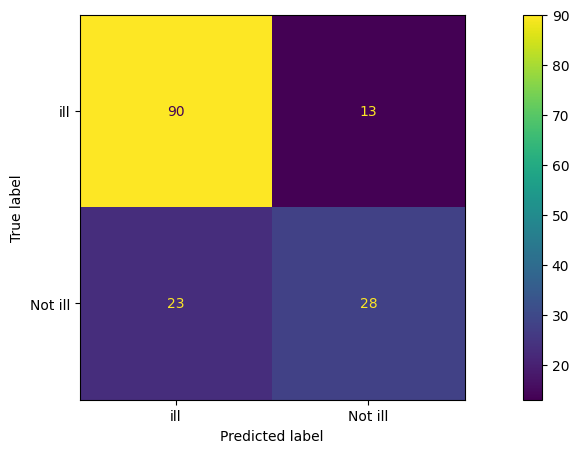

####################  ROS Balanced Dataset  ####################
Best model:  SVC(C=1, gamma=1, random_state=25)
Best model parameters:
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0      0.820     0.788     0.804       104
           1      0.780     0.812     0.796        96

    accuracy                          0.800       200
   macro avg      0.800     0.800     0.800       200
weighted avg      0.801     0.800     0.800       200



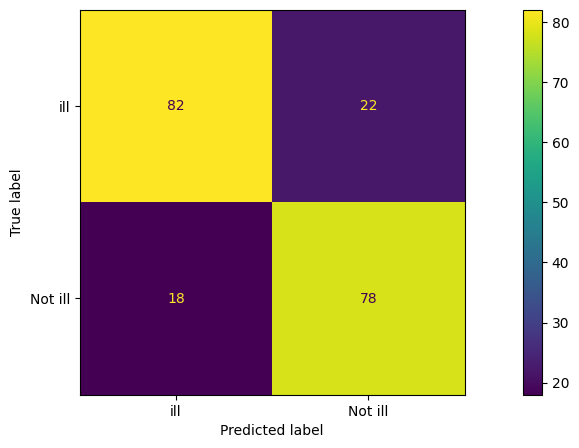

####################  SMOTE Balanced Dataset  ####################
Best model:  SVC(C=1, gamma=1, random_state=25)
Best model parameters:
{'C': 1, 'gamma': 1, 'kernel': 'rbf'}

              precision    recall  f1-score   support

           0      0.857     0.808     0.832       104
           1      0.804     0.854     0.828        96

    accuracy                          0.830       200
   macro avg      0.831     0.831     0.830       200
weighted avg      0.832     0.830     0.830       200



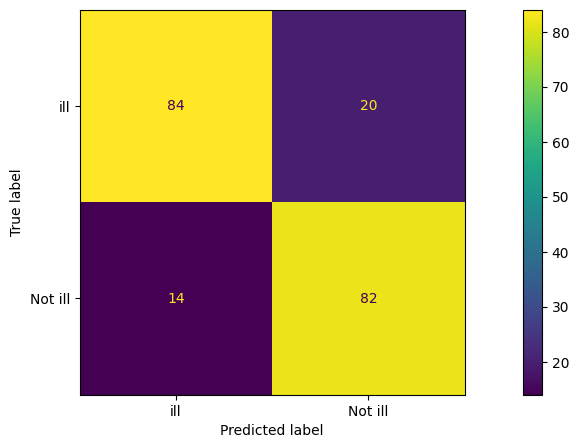

In [115]:
test_evaluation(ML_best_model, ML_best_params, X_train, y_train, X_test, y_test, "Original Dataset")
test_evaluation(ros_best_model, ros_best_params, ros_X_train, ros_y_train, ros_X_test, ros_y_test, "ROS Balanced Dataset")
test_evaluation(smote_best_model, smote_best_params, smote_X_train, smote_y_train, smote_X_test, smote_y_test, "SMOTE Balanced Dataset")

### Retrain and save model

In [19]:
# x = pd.concat((X_train, X_test))
# y = pd.concat((y_train, y_test))
# best_model.fit(x, y)
# 
# models_path = "models"
# if not os.path.exists(models_path):
#     os.mkdir(models_path)
# pickle.dump(best_model, open(os.path.join(models_path, "diabet_prediction_model.pkl"), "wb"))